In [2]:
# importing all the packages.
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
import json
from collections import Counter
from matplotlib import pyplot as plt
import math
import numpy as np
from datetime import datetime

#WordCloud 
from wordcloud import WordCloud

#Regex
import re

#NLTK
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer

#GENSIM
import gensim
from gensim.models import Phrases

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /home/repl/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /home/repl/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/repl/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Question 1

In [3]:
# PROBLEM DESCRIPTION:

# Convert the JSON file to a CSV file. 
# The CSV needs to save the following information. 
# Sort the data in the ascending order of id_str

# ------------------------------------
# Converts the JSON file to a csv file
def load_json(file_name):
    result=[]
    with open(file_name, 'r', encoding = "utf-8") as fp:
        line=fp.readline()
        while line:
            tobj = json.loads(line)
            
            # Gets all the user mentions from the JSON file
            mentions = tobj["entities"]["user_mentions"]
            
            # Sorts the user mentions by its screen name
            mention_list = sorted([m["screen_name"] for m in mentions])
            # Gets rid of duplicate mentions from mention_list
            newMention_list = []
            [newMention_list.append(x) for x in mention_list if x not in newMention_list]

            # Joins the mentions in newMention_list by a bar and replaces the '@' keyword with whitespace
            mentions_list = '|'.join(newMention_list).replace("@", "")
           
            # Gets all the hashtags from the JSON file
            hashtags = tobj["entities"]["hashtags"]
            
            # Sorts the hashtags by its text
            hashtag_list = sorted([h["text"] for h in hashtags])
            
            # Gets rid of duplicate hashtags from hashtag_list
            newHashtag_list = []
            [newHashtag_list.append(x) for x in hashtag_list if x not in newHashtag_list]
            
            # Joins the hashtags in newHashtag_list by a bar and replaces the '#' keyword with whitespace
            hashtags_list = '|'.join(newHashtag_list).replace("#", "")
            
            # Creates a dictionary containing the necessary information
            d = {
                "created_at": tobj["created_at"],
                "id_str": tobj["id_str"],
                "full_text": tobj["full_text"],
                "favorite_count": tobj["favorite_count"],
                "retweet_count": tobj["retweet_count"],
                "user_id_str": tobj["user"]["id_str"],
                "user_screen_name": tobj["user"]["screen_name"],
                "user_location": tobj["user"]["location"],
                "user_description": tobj["user"]["description"],
                "user_friends_count": tobj["user"]["friends_count"],
                "user_followers_count": tobj["user"]["followers_count"],
                "hashtags": hashtags_list,
                "mentions": mentions_list
            }
            
            # Appends the dictionary to a list
            result.append(d)
            line=fp.readline()
    return result

input_file="input.json"
data_list = load_json(input_file)

# Creates a dataframe from the function information and the given JSON file (input_file)
df = pd.DataFrame(data_list)

# Sorts the dataframe by its id_str
df1 = df.sort_values(by = 'id_str')
df1.head()

,created_at,id_str,full_text,favorite_count,retweet_count,user_id_str,user_screen_name,user_location,user_description,user_friends_count,user_followers_count,hashtags,mentions
1808,Wed Jul 01 16:44:52 +0000 2020,1278368987600936962,RT @funder: Vote Biden. He’ll never side with ...,0,1900,971161855702913024,DougHarding7,"Mission Viejo, CA","Vote Blue America, Let’s hire Mark KellyAZ, Sa...",8180,7536,,funder
1615,Wed Jul 01 16:45:28 +0000 2020,1278369140542255106,Trump-Pence 2020 https://t.co/HAZGfdFMXf,0,0,48153855,umbr52643,PA,"I am Pro-Life, Pro-Peace.",1891,764,,
1961,Wed Jul 01 16:45:56 +0000 2020,1278369258037227521,@realDonaldTrump @NYCMayor Old racist man shak...,0,0,827877954965344256,KP23114,"Pennsylvania, USA",Midwife. Mother. Pissed. trump’s an asshole.,881,232,,NYCMayor|realDonaldTrump
1640,Wed Jul 01 16:45:59 +0000 2020,1278369267935657984,RT @brett_mcgurk: New WH explanation is absurd...,0,12287,275343068,victorialrudd,,,156,596,,brett_mcgurk
485,Wed Jul 01 16:46:00 +0000 2020,1278369275661529089,RT @joyce_tyler: @PoliticusSarah @wandainparis...,0,3,970577438,kmeeo,Colorado,"""The ignorance of one voter in a democracy imp...",14612,14488,,MollyJongFast|PoliticusSarah|TheRickWilson|joy...


# Question 2

                            location  tweet_count
user_location                                    
Texas, USA                Texas, USA           35
Florida, USA            Florida, USA           30
California, USA      California, USA           29
New York, USA          New York, USA           14
Pennsylvania, USA  Pennsylvania, USA           13


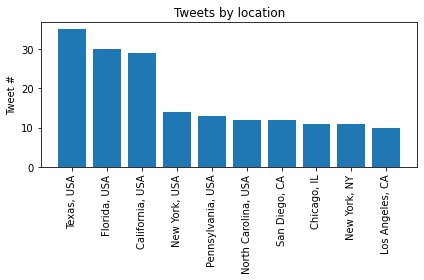

In [10]:
# PROBLEM DESCRIPTION:

# Identify the top 10 user locations (except for empty location, United States, and USA). 
# Visualize how many tweets are posted by users from each of the 10 locations in a bar chart. 
# Sort the locations by the number of tweets in descending order. 
# If two locations have the same tweet_count, sort them in ascending alphabetic order of location

# -------------------------------------------------------
# Finds all the tweets that don't contain the given words
loc_df = df[~df["user_location"].isin(["", "United States", "USA"])]

# Group the tweets by its user location
group = loc_df.groupby(by = ["user_location"])
count_ser = group.user_location.count()
location_ser = group.user_location.first()

# Creates a dataframe with the user location and tweet count of each tweet 
location_df = pd.DataFrame(data = {"location": location_ser, "tweet_count": count_ser})

# Sorts the dataframe and gets the top 10 user locations from it 
df2 = location_df.sort_values(by = ["tweet_count", "location"], ascending = [False, True]).iloc[:10]
print(df2.head())

# Gets the top 10 locations and tweet count and uses this to create the visualization
locations = df2["location"]
tweets = df2["tweet_count"]

# Creating the visualization
plt.bar(locations, tweets)
plt.xticks(rotation = 90)
plt.title("Tweets by location")
plt.ylabel("Tweet #")
plt.tight_layout()

# Question 3

                       date  tweet_count  retweet_count
created_at_date                                        
2020-07-01       2020-07-01            2           1903
2020-07-03       2020-07-03            7          21361
2020-07-04       2020-07-04            2            485
2020-07-05       2020-07-05            1            175
2020-07-06       2020-07-06            4          54277


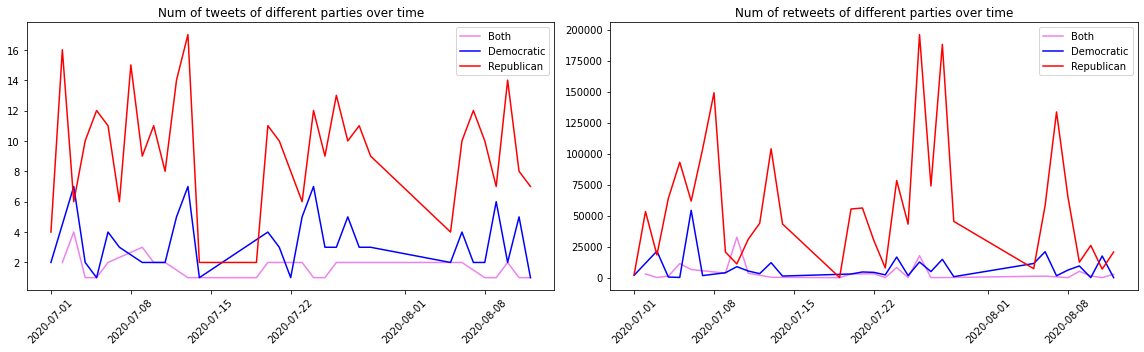

In [9]:
# PROBLEM DESCRIPTION:

# Visualize the number of tweets and retweets over the time of different user groups. 
# You need to categorize the users by whether their descriptions contain any "party keywords" 
# (by checking substring, case sensitive).

# Democratic keywords: ["DNC", "TheDemocrats", "Biden", "JoeBiden", "Our best days still lie ahead", and "No Malarkey!"]

# Republican keywords: ["#MAGA2020", "#NovemberElection" ,"GOP", "Trump", "POTUS", "realDonaldTrump", 
# "Pence", "Mike_Pence", and "VP", "Keep America Great"]

# If a user description only contains democratic keywords, categorize the user as "Democratic". 
# If a user description only contains republican keywords, categorize the user as a "Republican". 
# If the user description has keywords in both lists, categorize the user as "Both". 
# If no keywords appear in the user description, categorize the user as "None".

# -------------------------------------------
democratic_keywords = ["DNC", "TheDemocrats", "Biden", "JoeBiden", "Our best days still lie ahead", "No Malarkey!"]
republican_keywords = ["#MAGA2020", "#NovemberElection" ,"GOP", "Trump", "POTUS", "realDonaldTrump", "Pence", "Mike_Pence", "VP", "Keep America Great"]

# Initializes dem, rep, both, or none parties for each tweet 
def demRep(party_words):
    democrats = False
    republicans = False
    
    for dem in democratic_keywords:
        if dem in party_words:
            democrats = True
            break
            
    for rep in republican_keywords:
        if rep in party_words:
            republicans = True
            break
        
    if democrats and not republicans:
        return "Democratic"
    elif republicans and not democrats:
        return "Republican"
    elif democrats and republicans:
        return "Both"
    else:
        return "None"
    
df3_party = df.copy()
party_list = []

for val in df3_party["user_description"]:
    pval = demRep(val)
    party_list.append(pval)

df3_party["party"] = party_list

date = []
for d in df3_party['created_at']:
    date.append(pd.to_datetime(d).date())
df3_party['created_at_date'] = date

# Creating sub section containing democratic tweets
df_party = df3_party.loc[df3_party.party == 'Democratic']
group = df_party.groupby(by = ["created_at_date"])
tweet_ser_dem = group.created_at_date.count()
retweet_ser_dem = group.retweet_count.sum()
date_ser_dem = group.created_at_date.first()

# Creating sub section containing republican tweets
df_party = df3_party.loc[df3_party.party == 'Republican']
group = df_party.groupby(by = ["created_at_date"])
tweet_ser_rep = group.created_at_date.count()
retweet_ser_rep = group.retweet_count.sum()
date_ser_rep = group.created_at_date.first()

# Creating sub section containing both tweets
df_party = df3_party.loc[df3_party.party == 'Both']
group = df_party.groupby(by = ["created_at_date"])
tweet_ser_both = group.created_at_date.count()
retweet_ser_both = group.retweet_count.sum()
date_ser_both = group.created_at_date.first()

# Saving dataframe to a csv file
df3 = pd.DataFrame(data = {"date": date_ser_dem, "tweet_count": tweet_ser_dem, "retweet_count": retweet_ser_dem})
print(df3.head())

# Creating the visualizations
plt.figure(figsize = (16, 5))
plt.subplot(1, 2, 1)
plt.plot(date_ser_both, tweet_ser_both, color = 'violet', label = 'Both')
plt.plot(date_ser_dem, tweet_ser_dem, color = 'b', label = 'Democratic')
plt.plot(date_ser_rep, tweet_ser_rep, color = 'r', label = 'Republican')
plt.xticks(rotation = 45)
plt.title("Num of tweets of different parties over time")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(date_ser_both, retweet_ser_both, color = 'violet', label = 'Both')
plt.plot(date_ser_dem, retweet_ser_dem, color = 'b', label = 'Democratic')
plt.plot(date_ser_rep, retweet_ser_rep, color = 'r', label = 'Republican')
plt.xticks(rotation = 45)
plt.title("Num of retweets of different parties over time")
plt.legend(loc = "best")
plt.tight_layout()

# Question 4

        star  Democratic  Republican  Both
0    regular          55         186    21
1       star          28          71    14
2  superstar          16          56     5


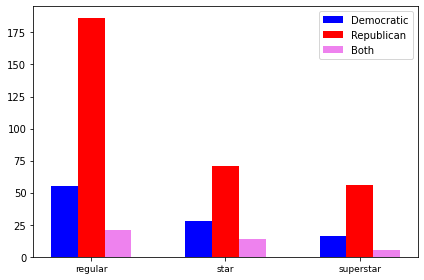

In [8]:
# PROBLEM DESCRIPTION:

# Visualize the number of regular, star, and superstar users of Democratic, Republican, and Both groups. 
# Categorize the users by the number of followers. If a user has more than 10000 followers, 
# categorize the user as a "superstar". If the user has more than 3000 but less than or equal to 10000 followers, 
# categorize the user as "star". If the user has less than or equal to 3000 followers, categorize the user as "regular". 
# Use the definition of party from Q3. Use a bar chart to visualize how many users in dem, rep, and both groups 
# are regular, star, and superstar (order must be dem, rep, both, and regular, star, superstar)

# ----------------------------------------------------------------
df3_party.drop_duplicates(subset = ['user_id_str'], inplace = True)

# Gets a dataframe with all the parties 
def party_series(df_party):
    regular = df_party.loc[(df_party.user_followers_count <= 3000)]["user_followers_count"].count()
    star = df_party.loc[(df_party.user_followers_count > 3000) & (df.user_followers_count <= 10000)]["user_followers_count"].count()
    superstar = df_party.loc[(df_party.user_followers_count > 10000)]["user_followers_count"].count()
    party_series = [regular, star, superstar]
    return party_series

star_series = ["regular", "star", "superstar"]

# Locates all dems, reps, and both in the dataframe 
df_party_dem = df3_party.loc[df3_party.party == 'Democratic']
df_party_rep = df3_party.loc[df3_party.party == 'Republican']
df_party_both = df3_party.loc[df3_party.party == 'Both']

#Creates a dataframe with all the parties
df4 = pd.DataFrame(data = {"star": star_series})
df4["Democratic"] = party_series(df_party_dem)
df4["Republican"] = party_series(df_party_rep)
df4["Both"] = party_series(df_party_both)
print(df4.head())
# Creating the visualizations
plt.figure(figsize = (6, 4))
x_value = range(len(party_series(df_party_dem)))
width = 0.2

plt.bar([x - 1 * width for x in x_value], party_series(df_party_dem), width, color = 'blue', label = "Democratic")
plt.bar([x + 0 * width for x in x_value], party_series(df_party_rep), width, color = 'r', label = "Republican")
plt.bar([x + 1 * width for x in x_value], party_series(df_party_both), width, color = 'violet', label = "Both")

x_ticks = ["regular", "star", "superstar"]
plt.xticks(x_value, x_ticks, fontsize = 9)
plt.legend(loc = "best")
plt.tight_layout()

# Question 5

   keyword  count       party
0    putin      7  Democratic
2     want      6  Democratic
3     like      6  Democratic
1  america      6  Democratic
4    state      5  Democratic


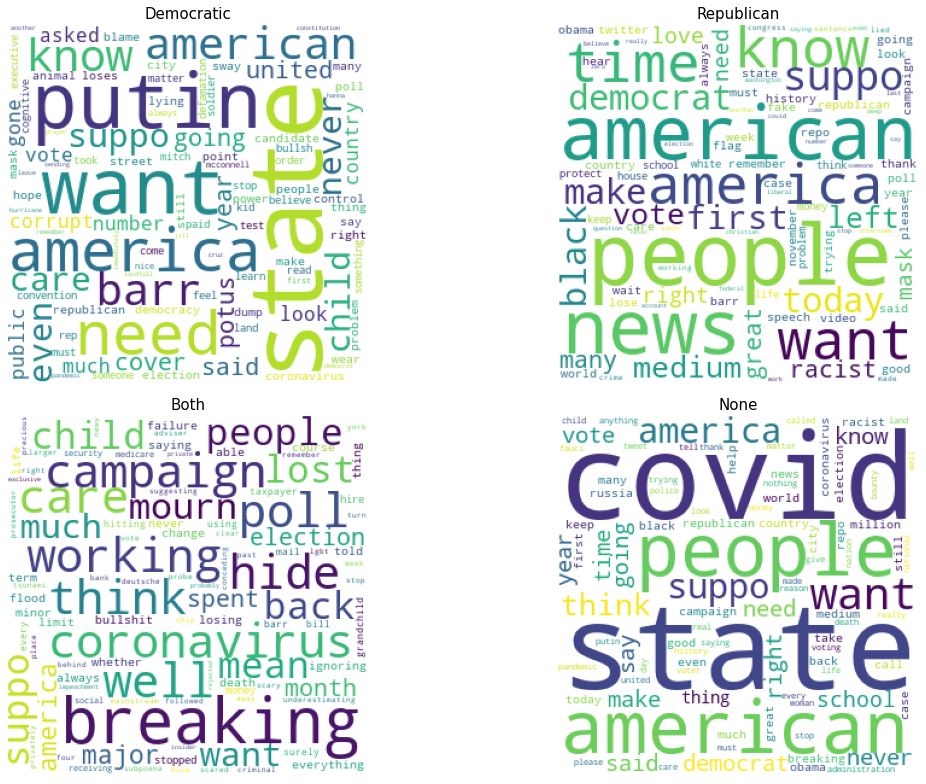

In [11]:
# PROBLEM DESCRIPTION:

# Generate word cloud visualization for Democratic, Republican, Both and None groups. 
# The definition of party groups is the same as Q3. 

# The text cleaning should:
# · Remove urls, RT, @mention, #hashtags, and &html markups.
# · Remove Donald, donald, Trump, trump, Biden, biden, President, and president
# · Convert all words to lower case.
# · Remove stopwords and words shorter than 4 characters.
# · All words need to be lemmatized but not stemmed.
# · Common bigrams must be combined (use 5 as min appearance time and space as delimiter).

# After cleaning, for each of the four groups, find 100 keywords with the highest count 
# (different groups have different 100 keywords). For each tweet, only keep words that are keywords. 
# Use each group's keywords to generate the word cloud visualizations 
# (therefore, visualization only contains keywords of each group)

# ---------------------------
df5 = df3_party.copy()

# Converts the text to a list of tokens and removes unnecessary words
def text2tokens(text):
    text = text.lower()
    text = re.sub(r"http.+|@\w+|#\w+|rt|&\w|donald|trump|biden|president", " ", text.lower())
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 3]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens

df5["tokens"] = df5.full_text.apply(text2tokens)

bigram = Phrases(df5.tokens, min_count = 5, delimiter = ' ')
bigrams = [bigram[d] for d in df5["tokens"]]
df5["bigrams"] = bigrams

df_party_dem = df5.loc[df5.party == 'Democratic']
df_party_rep = df5.loc[df5.party == 'Republican']
df_party_both = df5.loc[df5.party == 'Both']
df_party_none = df5.loc[df5.party == 'None']

#Gets the data frames for each party group
def wordCloud(df_party, party_name):
    
    words = []
    for bigrams in df_party.bigrams:
        words.extend(bigrams)
    counter = Counter(words)
    
    # Gets the top 100 most common words
    counter = counter.most_common(100)
    
    main_words = []
    main_count = []
    main_party = []
    for w, f in counter:
        main_words.append(w)
        main_count.append(f)
        main_party.append(party_name)
        
    df_party = pd.DataFrame(data = {"keyword": main_words, "count": main_count, "party": main_party})
    new_df = df_party.sort_values(by = ["count"], ascending = [False])
    return new_df

dem_df = wordCloud(df_party_dem, "Democratic")
rep_df = wordCloud(df_party_rep, "Republican")
both_df = wordCloud(df_party_both, "Both")
none_df = wordCloud(df_party_none, "None")

# Concatenating all four dataframes into one data frame
df_array = [dem_df, rep_df, both_df, none_df]
final_df = pd.concat(df_array)

print(final_df.head())

#Creating the word cloud visualizations
def displayWordCloud(x, y, z, keywords, title):
    plt.subplot(x, y, z)
    text = " ".join(keywords)

    wordcloud = WordCloud(width = 300, height = 300, background_color = "white", min_font_size = 5).generate(text)
    plt.title(title, fontsize = 15)
    plt.imshow(wordcloud)

# Plotting the visualizations
plt.figure(figsize = (18, 11))
displayWordCloud(2, 2, 1, dem_df["keyword"], "Democratic")
plt.axis('off')

displayWordCloud(2, 2, 2, rep_df["keyword"], "Republican")
plt.axis('off')

displayWordCloud(2, 2, 3, both_df["keyword"], "Both")
plt.axis('off')

displayWordCloud(2, 2, 4, none_df["keyword"], "None")
plt.axis('off')

plt.tight_layout()